# enter model path

In [218]:
# path = '../log/geometric_graph/cube/checkpoints/best_model-step=14306.ckpt'
path = '../log/geometric_graph/grid/checkpoints/best_model-step=26783.ckpt'
# path = '../log/geometric_graph/torus/checkpoints/best_model-step=19563.ckpt'
# path = '../log/geometric_graph/trained on cluster/Grid2d-ss-bidirectional/checkpoints/best_model-step=3280.ckpt'
# path = '../log/geometric_graph/version_96/checkpoints/best_model-step=3081.ckpt'

In [1]:
# 127 works for grid with no persistence, not updating anchor feat, and reduced anchor edges
# version = 127
# 131 works kinda for grid with persistence, not updating anchor feat, and reduced anchor edges
# version = 131
# 135 works for grid with no persistence, angles, not updating anchor feat, and reduced anchor edges
# version = 135
# 136 works a bit for grid with persistence, angles, not updating anchor feat, and reduced anchor edges (trained too short probably)
# version = 136

version = 205

# version = None

# import packages and load model

In [2]:
import sys
sys.path.append('../')
import os

from utils.visualize import coord2scatter, plot_edge_index, plot_trend
from utils.utils import coord_invariant_rec_loss, damage_coord
import models
import egnn
from models import FixedTargetGAE

from pytorch_lightning.utilities.model_summary import ModelSummary
%matplotlib widget
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import torch

from importlib import reload
import data.datasets as datasets

reload(models)
reload(datasets)

import pools
reload(pools)

device = 'cpu'

if version is not None:
    path = f'../log/geometric_graph/version_{version}/checkpoints/'
    file_name = os.listdir(path)[0]
    path += file_name
    print(path)

model = FixedTargetGAE.load_from_checkpoint(path).to(device)
print(ModelSummary(model, max_depth=1))

../log/geometric_graph/version_205/checkpoints/best_model-step=4685.ckpt
  | Name    | Type         | Params
-----------------------------------------
0 | encoder | EncoderEGNCA | 8.7 K 
1 | mse     | MSELoss      | 0     
-----------------------------------------
8.7 K     Trainable params
0         Non-trainable params
8.7 K     Total params
0.035     Total estimated model params size (MB)


## notebook utils

In [3]:
box_dim = 1.0

coord_dim = model.encoder.coord_dim

def get_title(time_step, coord = None):
    title = '$t=%d$' % time_step
    if coord is not None:
        loss = coord_invariant_rec_loss(coord, model.target_coord)
        title += '$\quad \mathcal{L}_{\mathsf{INV}}=%.5f$' % loss
    return title

# initial and target geometric graphs

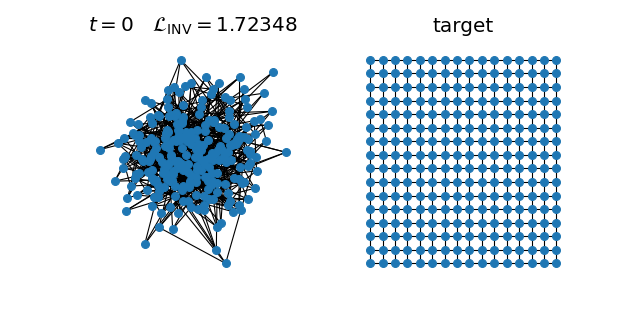

In [4]:
fig = plt.figure(figsize=(8, 4), dpi=80)
fig.tight_layout()

ax1 = fig.add_subplot(121, projection='3d' if coord_dim == 3 else None)
ax2 = fig.add_subplot(122, projection='3d' if coord_dim == 3 else None)

coord2scatter(model.init_coord, title=get_title(0, model.init_coord), transparent=True, ax=ax1, zero_center=False)
plot_edge_index(model.edge_index, coord=model.init_coord, title=get_title(0, model.init_coord), ax=ax1)
coord2scatter(model.target_coord, title='target', transparent=True, ax=ax2, zero_center=False)
plot_edge_index(model.edge_index, coord=model.target_coord, title='target', ax=ax2)

# transition rule dynamics animation

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
torch.Size([256, 16])


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 45.01it/s]


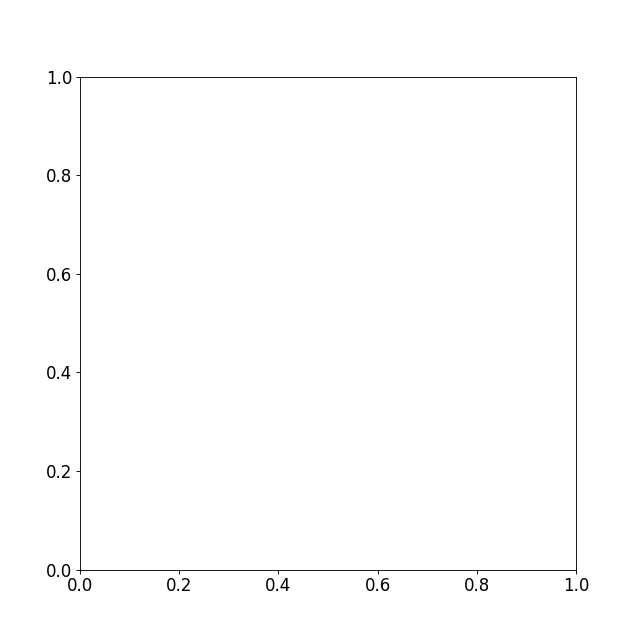

In [5]:
inter_coords, inter_node_feats = model.eval(n_steps=50, rotate=True, return_inter_states=True)

def animate(t):
    ax.clear()
    coord2scatter(inter_coords[t], box_dim=box_dim * 2, ax=ax, title=get_title(t, inter_coords[t]), zero_center=True)#, feat=inter_node_feats[t])
    # plot_edge_index(model.edge_index, coord=inter_coords[t]), box_dim=box_dim, ax=ax, title=get_title(t, inter_coords[t]))

fig = plt.figure(figsize=(8, 8), dpi=80)
fig.tight_layout()
ax = fig.add_subplot(projection='3d' if coord_dim == 3 else None)
ani = animation.FuncAnimation(fig, animate, frames=range(len(inter_coords)), interval=500, repeat=False)
# ani.save('evolve.gif', dpi=300, writer=animation.PillowWriter(fps=2))

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
torch.Size([256, 16])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 59.57it/s]


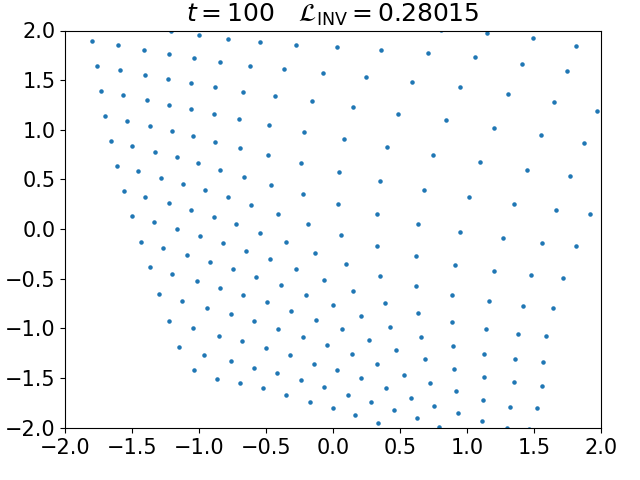

In [22]:
n_steps = 100
final_coord, final_node_feat = model.eval(n_steps=n_steps, rotate=True)
fig = coord2scatter(final_coord, title=get_title(n_steps, final_coord), box_dim=box_dim*2, zero_center=True)
# plot_edge_index(model.edge_index, coord=final_coord.detach().cpu().numpy(), title=get_title(n_steps, final_coord))

# regeneration

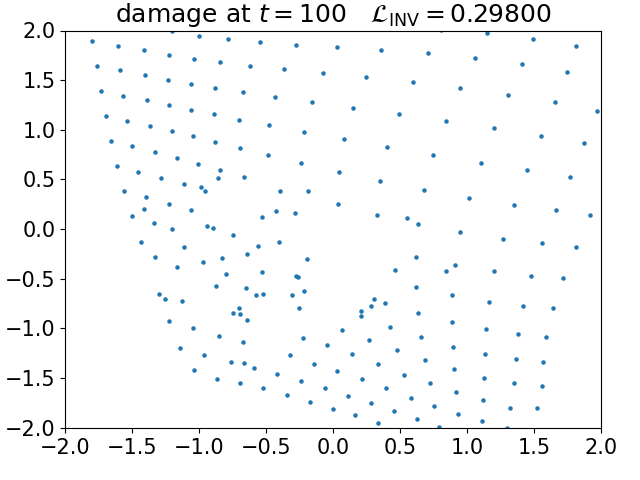

In [24]:
damaged_coord = damage_coord(final_coord, std=0.25, radius=1.0) # , radius=1.0
coord2scatter(damaged_coord, box_dim=box_dim*2, title='damage at ' + get_title(n_steps, damaged_coord))

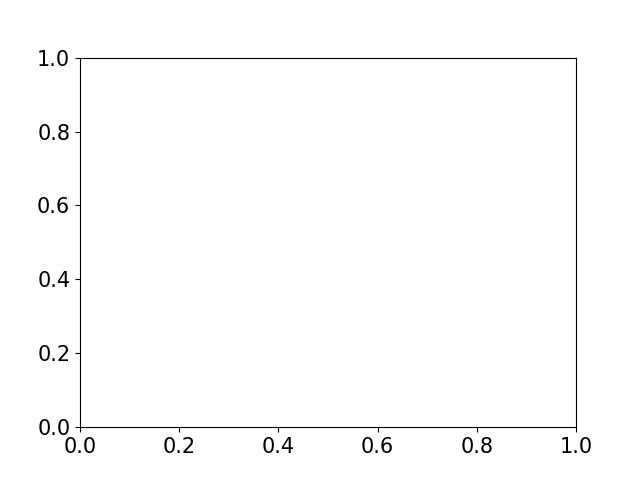

In [27]:
regenerated_coords = model.eval(
    n_steps=50, init_coord=damaged_coord, init_node_feat=final_node_feat, return_inter_states=True)[0]

def animate(t):
    ax.clear()
    coord2scatter(regenerated_coords[t].detach(), box_dim=box_dim*2, ax=ax, title=get_title(t, regenerated_coords[t]))
    # plot_edge_index(model.edge_index, coord=renegerated_coords[t].detach().cpu().numpy(), box_dim=box_dim, ax=ax, title=get_title(t, regenerated_coords[t]))

fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(projection='3d' if coord_dim == 3 else None)
ani = animation.FuncAnimation(fig, animate, frames=range(len(regenerated_coords)), interval=500, repeat=False)
# ani.save('regenerate.gif', dpi=300, writer=animation.PillowWriter(fps=2))

In [9]:
n_regeneration_steps = 1000
regenerated_coord = model.eval(n_steps=n_regeneration_steps, init_coord=damaged_coord, init_node_feat=final_node_feat)[0]
coord2scatter(regenerated_coord, box_dim=box_dim, title=get_title(n_regeneration_steps, regenerated_coord))

100%|██████████| 1000/1000 [00:15<00:00, 63.31it/s]


<IPython.core.display.Javascript object>